In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = Path('/content/drive/MyDrive/Colab Notebooks/')


In [ ]:
folder = 'photo'
file = 'image.csv'

In [ ]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file,dest,max_pics=1000)

In [ ]:
verify_images(path/folder, delete=True)

cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000012.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000009.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000013.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000051.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000241.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000258.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000311.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/photo/00000354.jpg'>
cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/phot

In [ ]:
path_hr = path/'photo'
path_lr = path/'crappy'

In [ ]:
from PIL import ImageFont
fnt0 = ImageFont.truetype('/content/drive/MyDrive/FreeMono.ttf',30)
fnt =fnt = ImageFont.truetype('/content/drive/MyDrive/FreeMono.ttf', 10)

In [ ]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//6),random.randint(0,h//6)), str("00:28"), fill=(255,255,255), font=fnt)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str("CMHK"), fill=(255,255,255), font=fnt)
        ImageDraw.Draw(img).text((random.randint(w//2, w),random.randint(0,h//2)), str("99%"), fill=(255,255,255), font=fnt)
        ImageDraw.Draw(img).rectangle((70, 5, 90, 10), fill=(255,209,0))
        #img.save(dest, quality=q)
        img.save(dest)

In [ ]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [ ]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

In [ ]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(resize_method=ResizeMethod.SQUISH, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
data_gen = get_data(bs,size)

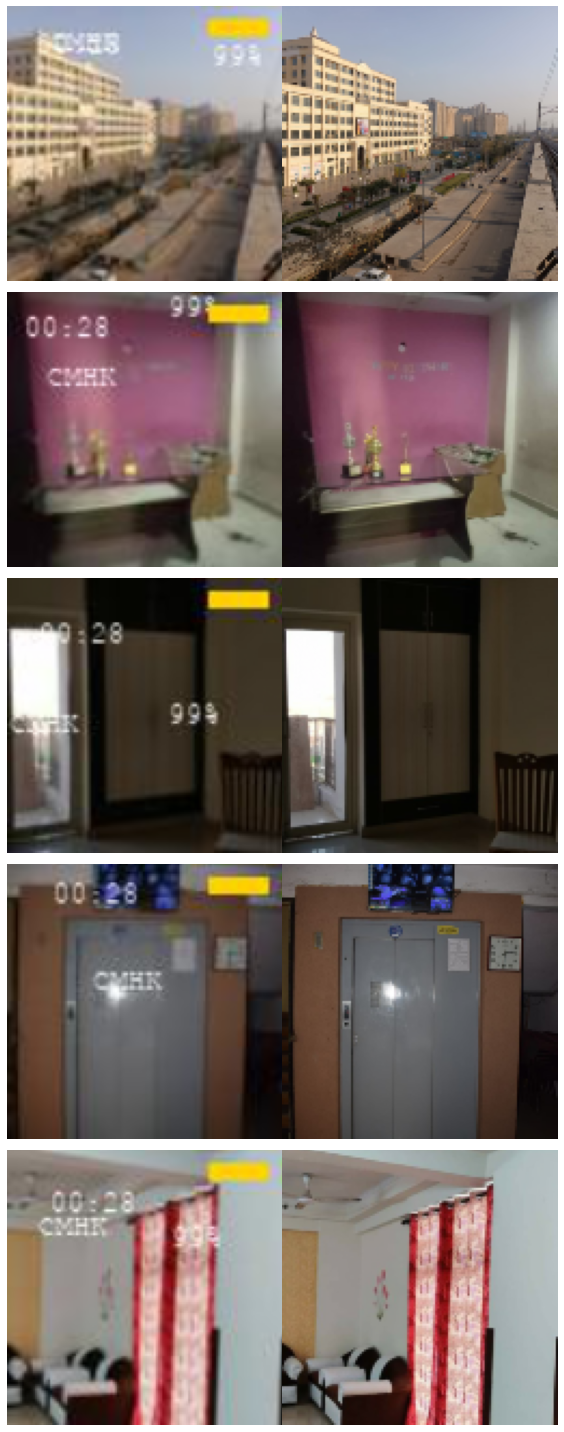

In [ ]:
data_gen.show_batch()

In [ ]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner()

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

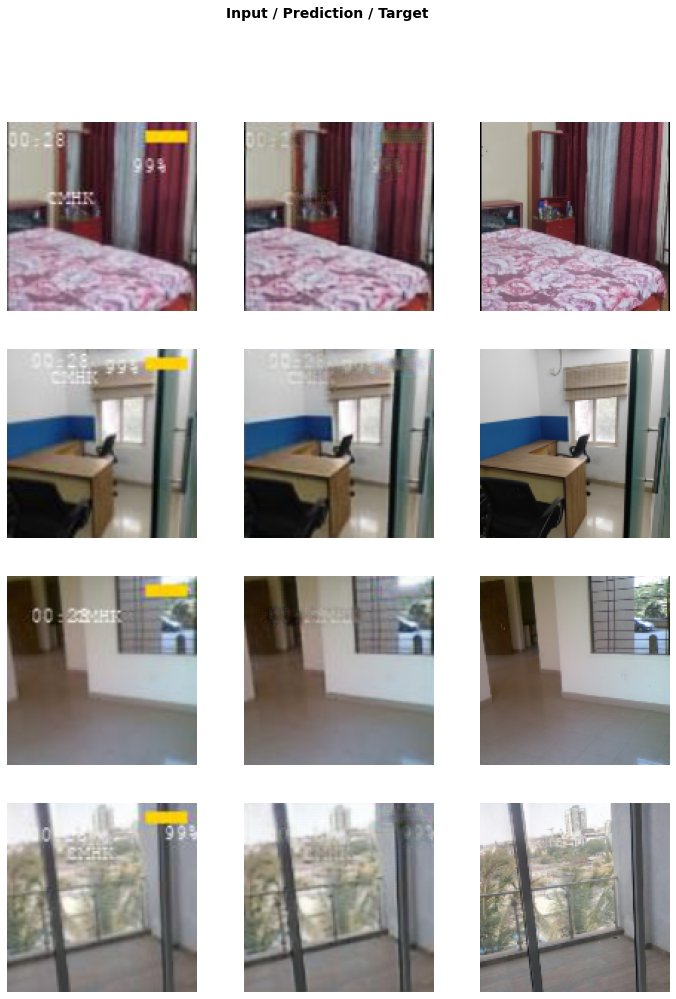

In [ ]:
learn_gen.show_results(rows=4)

In [ ]:
learn_gen.save('gen-pre2')

**Save generated Images**

In [ ]:
learn_gen.load('gen-pre2');

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

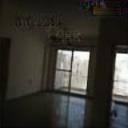

In [ ]:
PIL.Image.open(path_gen.ls()[0])

In [ ]:
learn_gen=None
gc.collect()

72

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(resize_method=ResizeMethod.SQUISH, size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

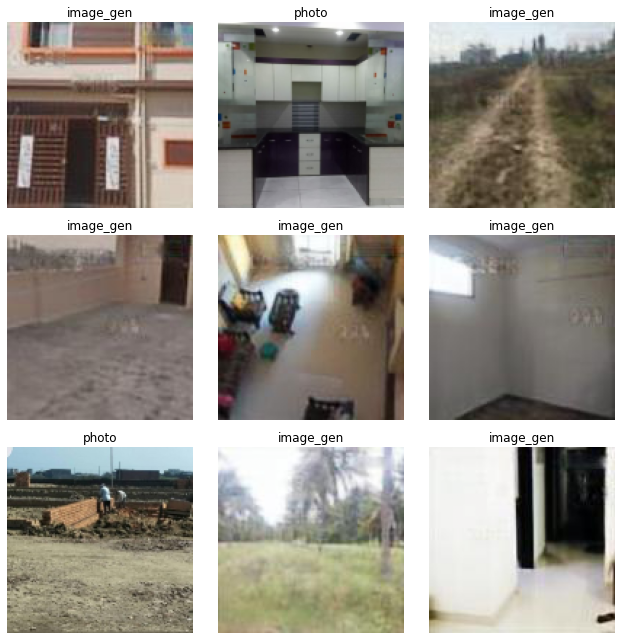

In [ ]:
data_crit = get_crit_data([name_gen, 'photo'], bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre2')

**GAN¶**

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

19579

In [ ]:
bs, size = 8, 128

In [ ]:
data_crit = get_crit_data(['crappy', 'photo'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by learn_crit.loss_func. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4
learn.fit(40,lr)

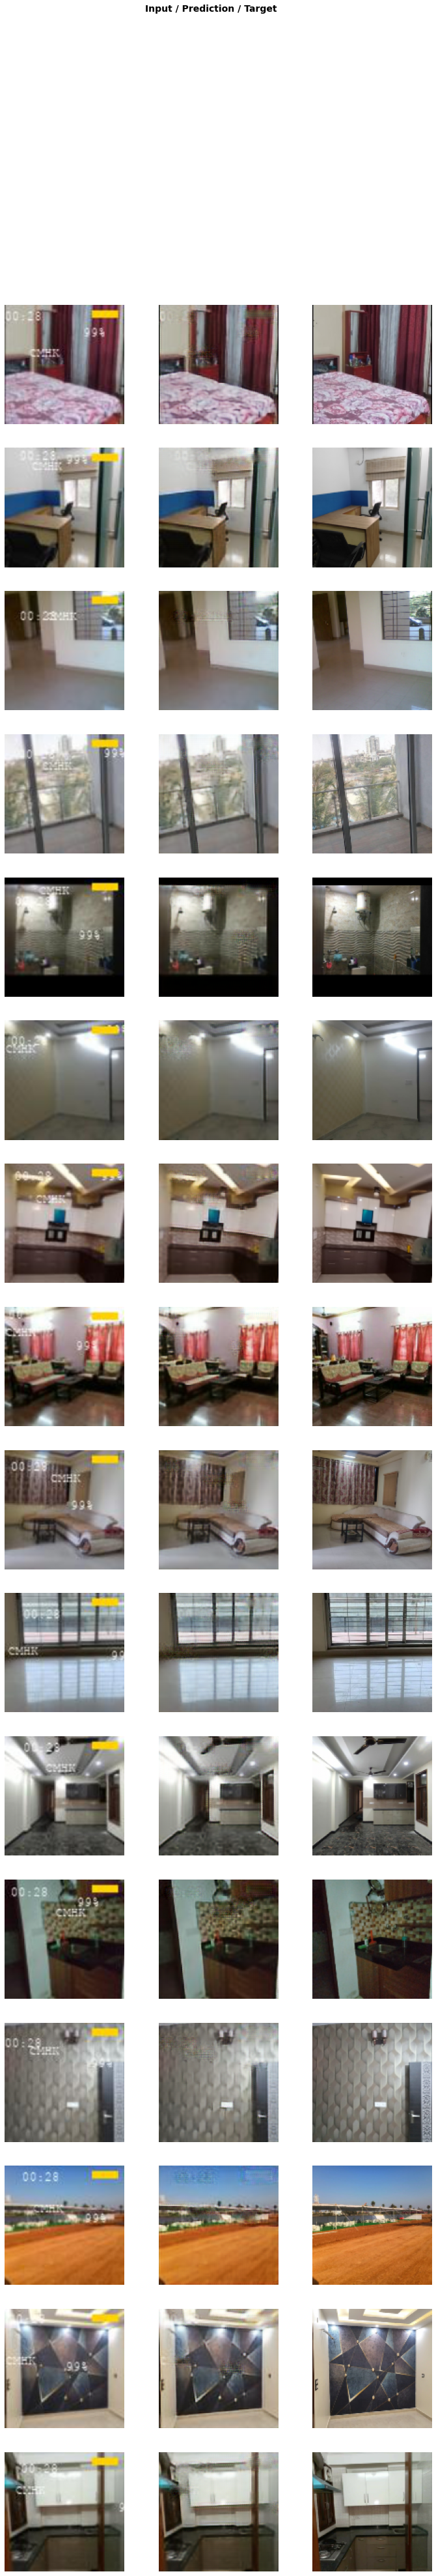

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

In [ ]:
learn.save('gan-1d')

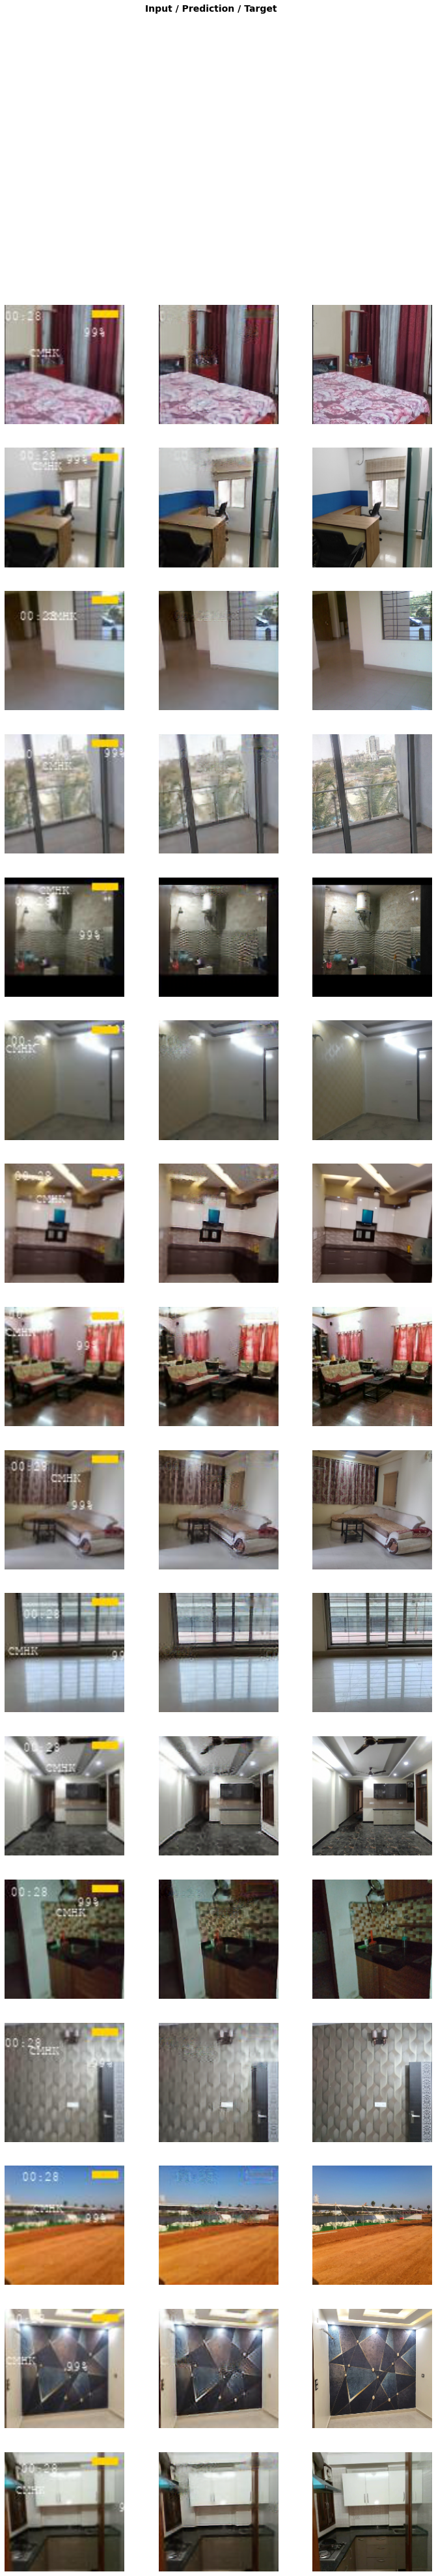

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn_gen.save('gen-1d')

In [ ]:
learn.data=get_data(3,256)
learn.fit(10,lr/2)

In [ ]:
learn.save('gan-1e')

In [ ]:
learn.load('gan-1e', purge=False)

GANLearner(data=ImageDataBunch;

Train: LabelList (864 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/drive/MyDrive/Colab Notebooks/crappy;

Valid: LabelList (96 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/drive/MyDrive/Colab Notebooks/crappy;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPoo

In [ ]:
def get_test_data(bs):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(resize_method=ResizeMethod.SQUISH, size=(1000), tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
learn.data = get_test_data(1)

In [ ]:
img = open_image('testing.jpg'); img.shape
p,img_hr,b = learn_gen.predict(img)

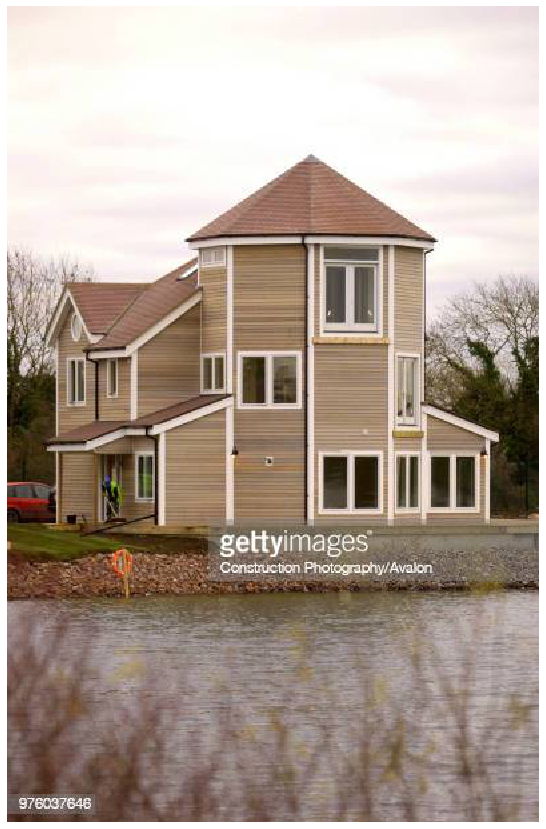

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
show_image(Image(img_hr).resize((3, 1280, 719)),figsize=(18,15), interpolation='nearest')

TypeError: ignored